In [1]:
# %%
from SonicBatt import utils
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import load_model

root_dir = utils.root_dir()
study_path = os.path.join(root_dir, 'studies', 'multi-cell_ml')
data_path = os.path.join(study_path, 'Raw Data')
ancillary_data_path = os.path.join(study_path, 'Ancillary Data')
unsupervised_models_path = os.path.join(study_path, 'Models', 'Unsupervised')
autoencoders_path = os.path.join(unsupervised_models_path, 'Autoencoders')

parquet_filename = 'signals_peaks_fft.parquet'
parquet_filepath = os.path.join(ancillary_data_path, parquet_filename)
df = pd.read_parquet(parquet_filepath)
# Get rid of the invariable parts of the acoustic signals
df = df.drop(columns = [('acoustics', str(i)) for i in range(758)])
spectrograms = np.load(os.path.join(ancillary_data_path, 'spectrograms.npy'))

# Shuffle and continue
indices_all = df.index.to_numpy().copy()
# !!! Instead of what didn't work --> #df.copy(deep=True).index.to_numpy()
#
np.random.seed(42)
np.random.shuffle(indices_all)

df = df.loc[indices_all].reset_index(drop=True)
spectrograms = spectrograms[indices_all]

# Replace cell_ids with the cell aliases
database = pd.read_excel(os.path.join(data_path, 'database.xlsx'))
df_cell_aliases =  pd.read_excel(os.path.join(data_path, 'database.xlsx'),
                              sheet_name='cell_aliases')
cell_aliases = {}
for _, row in df_cell_aliases.iterrows():
    cell_aliases[row['cell_id']] = row['cell_alias']
label_column = ('cycling', 'Cell_ID')
df[label_column] = df[label_column].replace(cell_aliases)
y = df.loc[:, label_column].to_numpy()


In [2]:
# %%
data_configs = {
    'B': ['peak_tofs'],
    'C': ['peak_tofs', 'peak_heights'],
    'D': ['acoustics'],
    'E': ['fft_magns'],
    'F': ['acoustics', 'fft_magns'],
    'G': 'spectrograms'
}


In [3]:
# %%
import json
with open(os.path.join(ancillary_data_path,'cells_together_split.json'), 'r') as fp:
    cells_together_split = json.load(fp)
with open(os.path.join(ancillary_data_path,'cells_separated_splits.json'), 'r') as fp:
    cells_separated_splits = json.load(fp)

def config_data(data_config, Fold = None):
    if Fold == None:
        train_indices = cells_together_split['train']
        val_indices = cells_together_split['val']
        test_indices = cells_together_split['test']
    else:
        train_indices = cells_separated_splits[Fold]['train']
        val_indices = cells_separated_splits[Fold]['val']
        test_indices = cells_separated_splits[Fold]['test']        
    #
    if data_config != 'G':
        feature_columns = data_configs[data_config]
        X_train = df.loc[train_indices, feature_columns].to_numpy()
        X_val = df.loc[val_indices, feature_columns].to_numpy()
        X_test = df.loc[test_indices, feature_columns].to_numpy()
    else:
        X_train = spectrograms[train_indices]
        X_val = spectrograms[val_indices]
        X_test = spectrograms[test_indices]
    #
    y_train = df.loc[train_indices, label_column].to_numpy().reshape(-1,1)
    y_val = df.loc[val_indices, label_column].to_numpy().reshape(-1,1)
    y_test = df.loc[test_indices, label_column].to_numpy().reshape(-1,1)
    #
    return (X_train, y_train, X_val, y_val, X_test, y_test)

def get_scalers(X_train):
    min_values = np.min(X_train, axis=0)
    max_values = np.max(X_train, axis=0)
    # Avoid division by zero by replacing zeros in (max_values - min_values) with ones
    range_values = np.where(max_values - min_values == 0, 1, max_values - min_values)
    return(min_values, range_values)

def scale_data(data, min_values, range_values):
    data_scaled = (data - min_values) / range_values
    return(data_scaled)

def unscale_data(scaled_data, min_values, range_values):
    data_unscaled = (scaled_data * range_values) + min_values
    return(data_unscaled)


Working on: autoencoder_sch2_D_scaled
Working on: autoencoder_sch2_F_scaled
Working on: autoencoder_sch2_G_scaled
Working on: conv_autoencoder_sch2_G_scaled
Progress: 0 out of 12 parts for this autoencoder
Progress: 1 out of 12 parts for this autoencoder
Progress: 2 out of 12 parts for this autoencoder
Progress: 3 out of 12 parts for this autoencoder
Progress: 4 out of 12 parts for this autoencoder
Progress: 5 out of 12 parts for this autoencoder
Progress: 6 out of 12 parts for this autoencoder
Progress: 7 out of 12 parts for this autoencoder
Progress: 8 out of 12 parts for this autoencoder
Progress: 9 out of 12 parts for this autoencoder
Progress: 10 out of 12 parts for this autoencoder
Progress: 11 out of 12 parts for this autoencoder


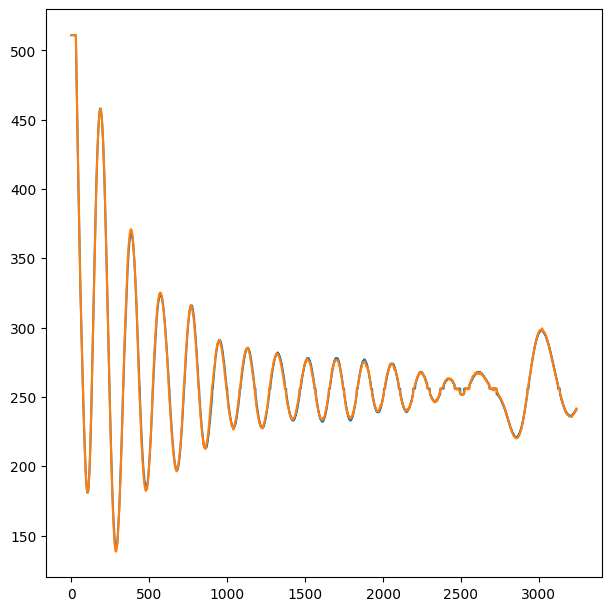

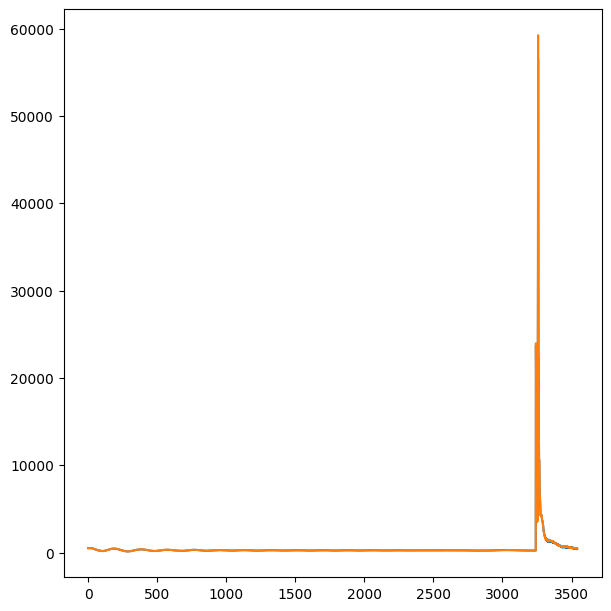

In [4]:
# %%
# Scaled
model_names = [
    'autoencoder_sch2_D_scaled',
    'autoencoder_sch2_F_scaled',
    'autoencoder_sch2_G_scaled',
    'conv_autoencoder_sch2_G_scaled'
]
data_configs_short = ['D', 'F', 'G', 'G']

for i in range(len(model_names)):
    data_config = data_configs_short[i]
    model_name = model_names[i]
    print('Working on: {}'.format(model_name))
    model_dir = os.path.join(autoencoders_path, model_name)
    model = load_model(os.path.join(model_dir, model_name))

    X_train, _, _, _, X_test, _ = config_data(data_config)
    min_values, range_values = get_scalers(X_train)
    X_test_scaled = scale_data(X_test, min_values, range_values)

    if model_name != 'conv_autoencoder_sch2_{}_scaled'.format(data_config):
        projected = model.encoder(X_test_scaled).numpy()
    else:
        del(df, X_train, spectrograms)
        for i in range(12):
            print('Progress: {} out of 12 parts for this autoencoder'.format(i))
            if i == 0:
                projected = model.encoder(X_test_scaled[(1000*i):(1000*(i+1))]).numpy()
            else:
                projected_small = model.encoder(X_test_scaled[(1000*i):(1000*(i+1))]).numpy()
                projected = np.concatenate((projected, projected_small), axis=0)
        projected_small = model.encoder(X_test_scaled[1000*(i+1):]).numpy()
        projected = np.concatenate((projected, projected_small), axis=0)

    if data_config != 'G':
        decoded_signals = model.decoder(projected).numpy()
        decoded_signals = unscale_data(decoded_signals, min_values, range_values)

        f, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
        ax.plot(np.arange(len(X_test[0])), X_test[0], color='tab:blue',
                label='original')
        ax.plot(np.arange(decoded_signals.shape[1]), decoded_signals[0], color='tab:orange',
                label='reconstructed')

    save_dir = os.path.join(autoencoders_path, '{}_projected.npy'.format(model_name))
    np.save(save_dir, projected)


In [5]:
# %%
